In [ ]:
import marimo as mo

# Bayesian Superiority Estimation with R2D2 Priors: A Practical Guide for Protein Screening

When screening hundreds of molecules, proteins, or interventions,
two critical questions often arise:

1. Is our experimental setup actually measuring the effect we care about
   (vs. experimental noise)?
2. Which candidates are truly superior to others?

In this tutorial, we'll tackle both challenges using a practical example:
a protein screening experiment with fluorescence readouts.
We'll show how **R2D2 priors** help interpret variance decomposition,
and how **Bayesian superiority calculation**
enables robust ranking of candidates.
Both techniques generalize to drug discovery, material science,
or any domain requiring rigorous comparison of multiple alternatives.

## The Protein Screening Example

We'll use a dataset with fluorescence measurements for over 100 proteins
across multiple experiments and replicates, with an experimental design that includes:

- A control protein present in all experiments and replicates
- "Crossover" proteins measured across all experiments
- Unique test proteins in each experiment

This design is common in high-throughput screening where measuring all proteins in all conditions is impractical.
We'll implement our analysis using PyMC, a powerful probabilistic programming framework for Bayesian modeling.

In [ ]:
import pymc as pm

## Generating Synthetic Data

To demonstrate our approach, we'll generate synthetic data that mimics a realistic protein screening experiment with:

- 3 experiments with 2 replicates each
- A control protein and crossover proteins present in all experiments
- Test proteins unique to each experiment
- Systematic experiment effects (batch effects)
- Replicate-level variation
- Measurement noise

In [ ]:
import numpy as np
import pandas as pd

# Set random seed for reproducibility
np.random.seed(42)

# Define parameters
n_experiments = 3
n_replicates = 2
n_proteins_per_exp = 40
n_crossover = 4

# Create protein names
control = ["Control"]
crossover_proteins = [f"Crossover_{i}" for i in range(n_crossover)]
other_proteins = [f"Protein_{i}" for i in range(100)]

# Base fluorescence values
base_values = {}
base_values["Control"] = 1000
for p in crossover_proteins:
    base_values[p] = np.random.normal(1000, 200)
for p in other_proteins:
    base_values[p] = np.random.normal(1000, 200)

# Create experiment effects
exp_effects = np.random.normal(1, 0.3, n_experiments)
rep_effects = np.random.normal(1, 0.1, (n_experiments, n_replicates))

# Generate data
data = []
for exp in range(n_experiments):
    # Select proteins for this experiment
    exp_proteins = (
        control + crossover_proteins + other_proteins[exp * 30 : (exp + 1) * 30]
    )

    for rep in range(n_replicates):
        for protein in exp_proteins:
            # Add noise and effects
            value = (
                base_values[protein]
                * exp_effects[exp]
                * rep_effects[exp, rep]
                * np.random.normal(1, 0.05)
            )

            data.append(
                {
                    "Experiment": f"Exp_{exp+1}",
                    "Replicate": f"Rep_{rep+1}",
                    "Protein": protein,
                    "Fluorescence": value,
                }
            )

# Convert to DataFrame
df = pd.DataFrame(data)
df

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Experiment</th>
      <th>Replicate</th>
      <th>Protein</th>
      <th>Fluorescence</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>Exp_1</td>
      <td>Rep_1</td>
      <td>Control</td>
      <td>1087.476281</td>
    </tr>
    <tr>
      <th>1</th>
      <td>Exp_1</td>
      <td>Rep_1</td>
      <td>Crossover_0</td>
      <td>1054.176224</td>
    </tr>
    <tr>
      <th>2</th>
      <td>Exp_1</td>
      <td>Rep_1</td>
      <td>Crossover_1</td>
      <td>955.647739</td>
    </tr>
    <tr>
      <th>3</th>
      <td>Exp_1</td>
      <td>Rep_1</td>
      <td>Crossover_2</td>
      <td>1091.751188</td>
    </tr>
    <tr>
      <th>4</th>
      <td>Exp_1</td>
      <td>Rep_1</td>
      <td>Crossover_3</td>
      <td>1189.344109</td>
    </tr>
    <tr>
      <th>...</th>
      <td>...</td>
      <td>...</td>
      <td>...</td>
      <td>...</td>
    </tr>
    <tr>
      <th>205</th>
      <td>Exp_3</td>
      <td>Rep_2</td>
      <td>Protein_85</td>
      <td>1765.149428</td>
    </tr>
    <tr>
      <th>206</th>
      <td>Exp_3</td>
      <td>Rep_2</td>
      <td>Protein_86</td>
      <td>1595.422298</td>
    </tr>
    <tr>
      <th>207</th>
      <td>Exp_3</td>
      <td>Rep_2</td>
      <td>Protein_87</td>
      <td>1889.585595</td>
    </tr>
    <tr>
      <th>208</th>
      <td>Exp_3</td>
      <td>Rep_2</td>
      <td>Protein_88</td>
      <td>1394.395041</td>
    </tr>
    <tr>
      <th>209</th>
      <td>Exp_3</td>
      <td>Rep_2</td>
      <td>Protein_89</td>
      <td>1411.831297</td>
    </tr>
  </tbody>
</table>
<p>210 rows × 4 columns</p>
</div>

In the synthetic dataset we've created, we simulated:

- 3 experiments with 2 replicates each
- A control protein and 4 crossover proteins present in all experiments
- 100 other proteins distributed across experiments
- Multiplicative experiment effects (mean=1, sd=0.3)
- Multiplicative replicate effects (mean=1, sd=0.1)
- Multiplicative measurement noise (mean=1, sd=0.05)

This structure simulates a typical screening setup
where batch effects between experiments are stronger than replicate variation,
and both contribute significantly to the observed fluorescence values.
The setting mirrors real experimental challenges
where we need to separate biological signal from technical noise.

## Examining the Raw Data

Before modeling, let's visualize the control and crossover proteins to understand experimental variation:

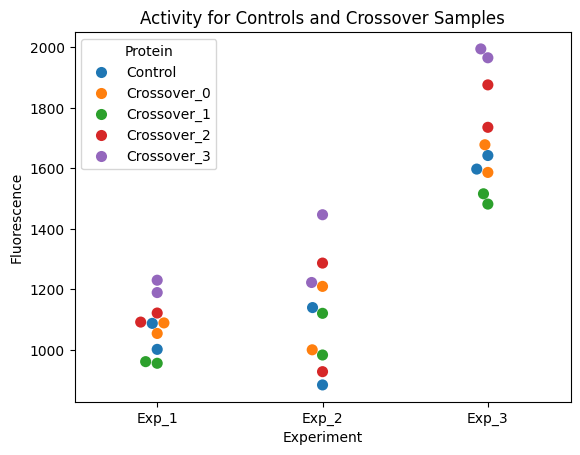

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter for Control and Crossover samples
mask = df["Protein"].str.contains("Control|Crossover")
filtered_df = df[mask]

# Create the swarm plot
sns.swarmplot(
    data=filtered_df, x="Experiment", y="Fluorescence", hue="Protein", size=8
)

plt.title("Activity for Controls and Crossover Samples")
plt.ylabel("Fluorescence")
plt.gca()

Notice the dramatic shift in fluorescence values across experiments.
Experiment 3 shows substantially higher fluorescence readings (around 1500-2000 units)
compared to Experiments 1 and 2 (mostly below 1300 units).

This pattern illustrates a common challenge in high-throughput screening:
significant batch effects between experiments that can mask the true biological signal.
Without accounting for these experimental factors, we might incorrectly attribute
higher activity to proteins simply because they were measured in Experiment 3.

Our modeling approach needs to account for both between-experiment and within-experiment
sources of variation to accurately compare proteins across the entire dataset.

## The R2D2 Prior for Variance Decomposition

The R2D2 prior (R-squared Dirichlet decomposition) provides an interpretable framework
for variance decomposition by placing a prior on the Bayesian coefficient of determination ($R^2$),
which then induces priors on individual parameters.

The core idea is simple but powerful:

1. Place a $\text{Beta}(a,b)$ prior on $R^2$ (the proportion of variance explained by the model)
2. Induce a prior on the global variance parameter representing total variance
3. Decompose the global variance into components via a Dirichlet distribution

This approach has key advantages over traditional hierarchical models:

- Instead of specifying arbitrary priors for each variance component separately, we control
  total explained variance through a single interpretable parameter ($R^2$)
- The variance partition becomes meaningful through the Dirichlet distribution
- The hierarchical nature ensures regularization of variance estimates

Here's our implementation of the model:

In [ ]:
def _():
    # Create categorical indices
    exp_idx = pd.Categorical(df["Experiment"]).codes
    rep_idx = pd.Categorical(df["Replicate"]).codes
    prot_idx = pd.Categorical(df["Protein"]).codes

    # Define coordinates for dimensions
    coords = {
        "experiment": df["Experiment"].unique(),
        "replicate": df["Replicate"].unique(),
        "protein": df["Protein"].unique(),
    }

    with pm.Model(coords=coords) as model:
        # Explicitly define R² prior (core of R2D2)
        r_squared = pm.Beta("r_squared", alpha=1, beta=1)

        # Global parameters
        global_mean = pm.Normal(
            "global_mean", mu=7, sigma=1
        )  # log scale for fluorescence

        # Prior on total variance, which will be scaled by R²
        # before being decomposed into components.
        sigma_squared = pm.HalfNormal("sigma_squared", sigma=1)

        # Global variance derived from R² and residual variance
        # For normal models: W = sigma² * r²/(1-r²)
        global_var = pm.Deterministic(
            "global_var", sigma_squared * r_squared / (1 - r_squared)
        )
        global_sd = pm.Deterministic(
            "global_sd", pm.math.sqrt(global_var)
        )  # noqa: F841

        # R2D2 decomposition parameters
        # 4 components: experiment, replicate (nested in experiment), protein,
        # and unexplained
        props = pm.Dirichlet("props", a=np.ones(4))

        # Component variances (for interpretability)
        exp_var = pm.Deterministic("exp_var", props[0] * global_var)
        rep_var = pm.Deterministic("rep_var", props[1] * global_var)
        prot_var = pm.Deterministic("prot_var", props[2] * global_var)
        unexplained_var = pm.Deterministic("unexplained_var", props[3] * global_var)

        # Component standard deviations
        exp_sd = pm.Deterministic("exp_sd", pm.math.sqrt(exp_var))
        rep_sd = pm.Deterministic("rep_sd", pm.math.sqrt(rep_var))
        prot_sd = pm.Deterministic("prot_sd", pm.math.sqrt(prot_var))
        unexplained_sd = pm.Deterministic(
            "unexplained_sd", pm.math.sqrt(unexplained_var)
        )

        # Component effects
        exp_effect = pm.Normal("exp_effect", mu=0, sigma=exp_sd, dims="experiment")
        rep_effect = pm.Normal(
            "rep_effect", mu=0, sigma=rep_sd, dims=("experiment", "replicate")
        )
        prot_effect = pm.Normal("prot_effect", mu=0, sigma=prot_sd, dims="protein")

        # Protein activity (what we're ultimately interested in)
        prot_activity = pm.Deterministic(  # noqa: F841
            "prot_activity", global_mean + prot_effect, dims="protein"
        )

        # Expected value
        y_hat = (
            global_mean
            + exp_effect[exp_idx]
            + rep_effect[exp_idx, rep_idx]
            + prot_effect[prot_idx]
        )

        # Calculate model R² directly (for verification)
        model_r2 = pm.Deterministic(  # noqa: F841
            "model_r2",
            (exp_var + rep_var + prot_var)
            / (exp_var + rep_var + prot_var + unexplained_var),
        )

        # Likelihood
        y = pm.Normal(  # noqa: F841
            "y", mu=y_hat, sigma=unexplained_sd, observed=np.log(df["Fluorescence"])
        )

        # Sample
        trace = pm.sample(
            2000, tune=1000, return_inferencedata=True, nuts_sampler="nutpie"
        )
    return model, trace

model, trace = _()

## Model Convergence and Variance Analysis

After fitting our model, zero divergent transitions confirm good convergence.

Let's examine how variance is partitioned across components:

In [ ]:
trace.sample_stats.diverging.sum()

<xarray.DataArray 'diverging' ()> Size: 8B
array(0) xarray.DataArray 'diverging' 0 array(0) Coordinates: (0) Indexes: (0) Attributes: (0)

In the ridgeline plot below, we see that unexplained variance contributes minimally to total variation,
while experiment and replicate effects—which ideally should contribute little—are actually
significant contributors to the readout variation. This serves as a metric of laboratory consistency.

Ideally, the protein variation (our biological signal of interest) should be the dominant source
of variation. This analysis suggests that improving experimental protocols to reduce batch effects
would substantially improve our signal-to-noise ratio.

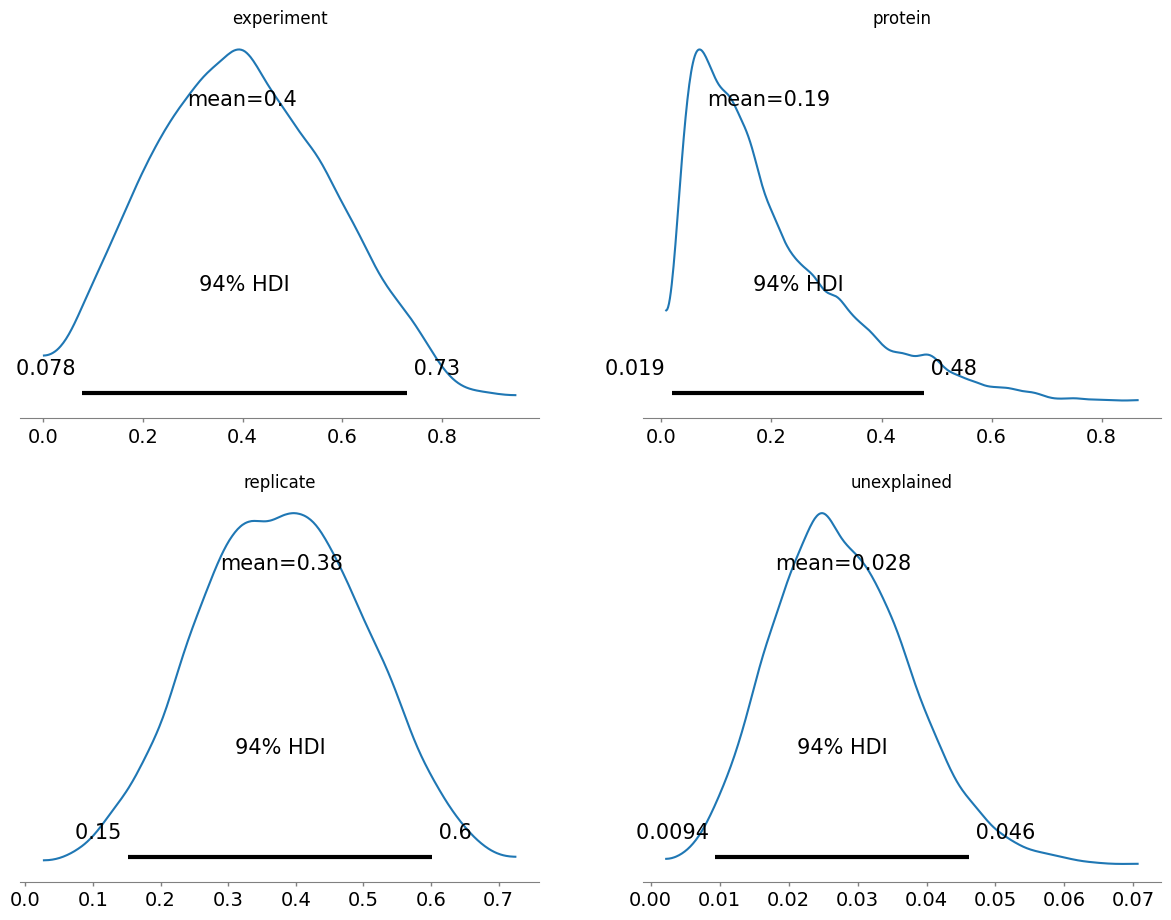

In [ ]:
import arviz as az

axes_posterior_props = az.plot_posterior(trace, var_names=["props"], grid=(2, 2))
axes_posterior_props.flatten()[0].set_title("experiment")
axes_posterior_props.flatten()[2].set_title("replicate")
axes_posterior_props.flatten()[1].set_title("protein")
axes_posterior_props.flatten()[3].set_title("unexplained")

These posterior plots show the distributions of the variance components. Each represents the proportion of total variance attributed to that component. We can see clear differences in the contributions from each source.

We can also look at the total $R^2$ value, which represents the proportion of variance explained by the model:

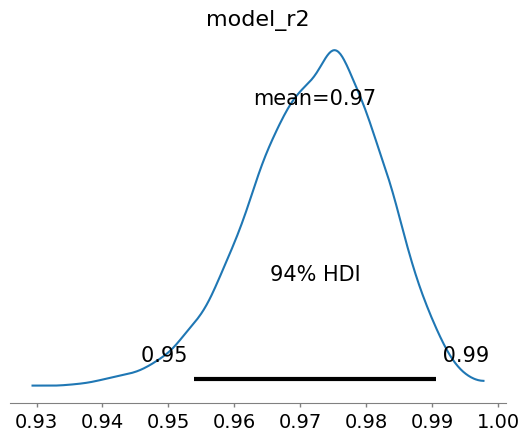

In [ ]:
az.plot_posterior(trace, var_names=["model_r2"])

Taken together, we can interpret that the model fits the data very well (`model_r2` close to 1), but it is concerning to me that protein only explains 19% of the variation in readout, while experiment and replicate explains more than 70% of the output variation, which signals to me that the measurements are not particularly tight, and a lot could be done to control experiment-to-experiment variation.

## Protein Activity Estimates

Now that we've decomposed the variance and accounted for experimental effects,
let's examine the protein activity estimates—the "true" biological signal after
removing experimental noise:

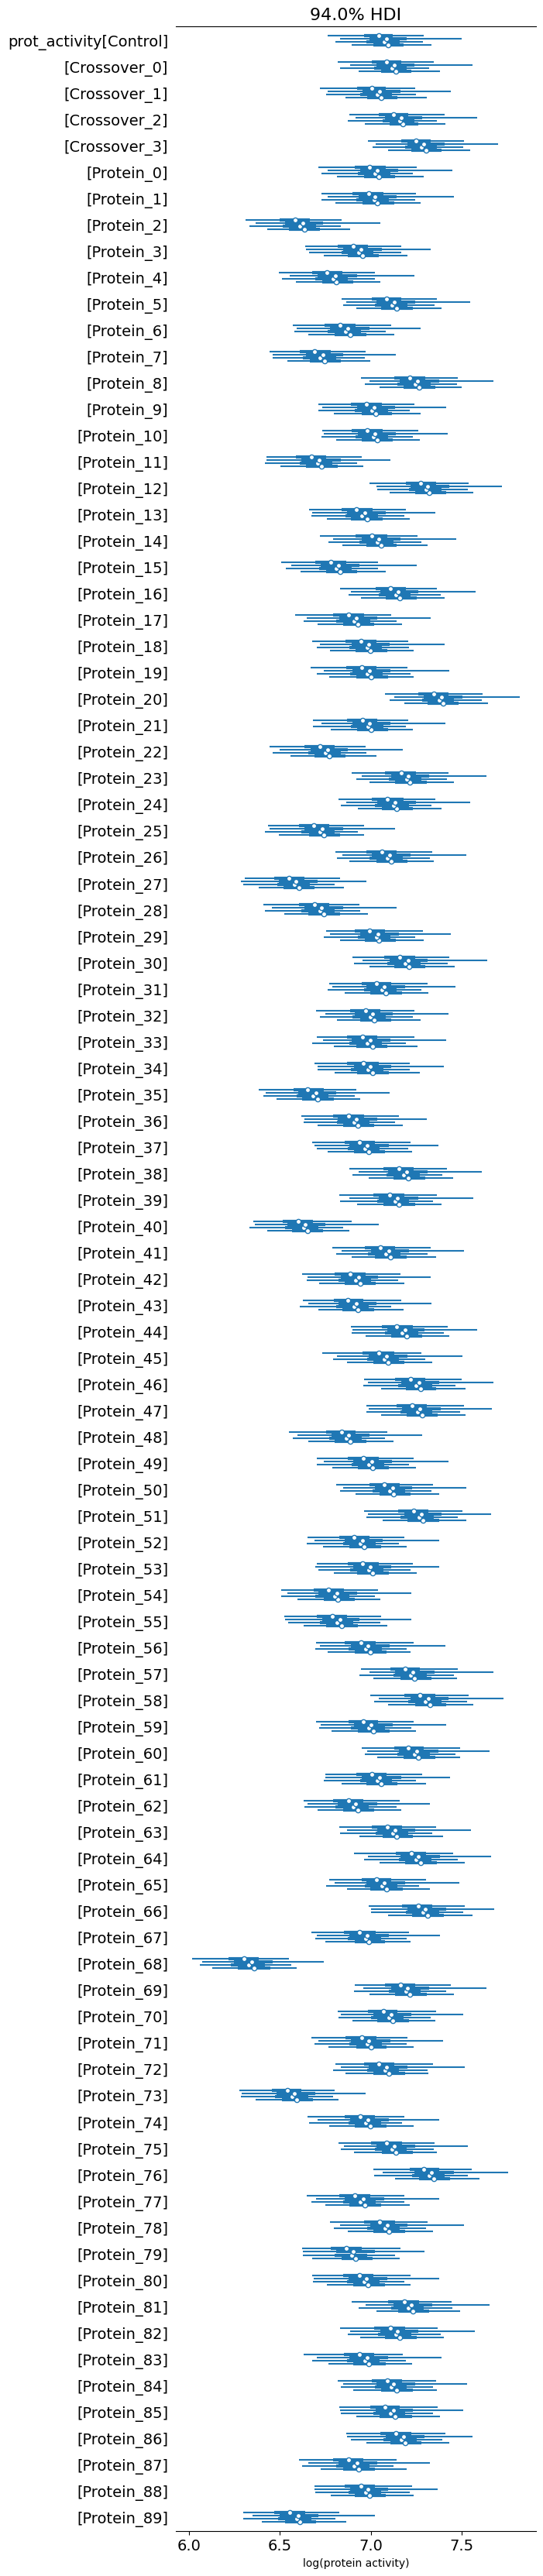

In [ ]:
ax = az.plot_forest(trace.posterior["prot_activity"])[0]
ax.set_xlabel("log(protein activity)")

The forest plot displays posterior distributions of protein activity (log scale),
with horizontal lines representing 94% credible intervals.

A key challenge emerges: despite similar uncertainty across proteins,
overlapping credible intervals make it difficult to determine which proteins
are truly superior. Simply ranking by posterior means could lead us to prioritize
proteins with slightly higher point estimates when uncertainty makes their actual
superiority ambiguous.

This is a fundamental limitation of ranking by point estimates alone:
it fails to properly account for uncertainty. A protein with a slightly lower mean
but narrower credible intervals might be a better candidate than one with a higher
mean but wider uncertainty bounds.

## Why not calculate the effect sizes?

While effect sizes quantify difference magnitudes, they have important limitations:

1. They still have posterior distributions with uncertainty
2. They require an arbitrary reference protein
3. Scale interpretation is subjective
4. They don't directly answer "which is better?"

This is where the probability of superiority calculation shines: it integrates over
the entire posterior distribution to directly answer our key question:
"What is the probability that protein A is better than protein B?"

The probability of superiority:

1. For each posterior sample, compares protein A's activity to protein B's
2. Counts the proportion of samples where A > B
3. Results in P(A > B) - a single number from 0 to 1

This approach integrates over uncertainty, directly answers our question,
avoids arbitrary references, and produces an intuitive metric for decision-making.

Let's illustrate this with a comparison between two specific proteins:

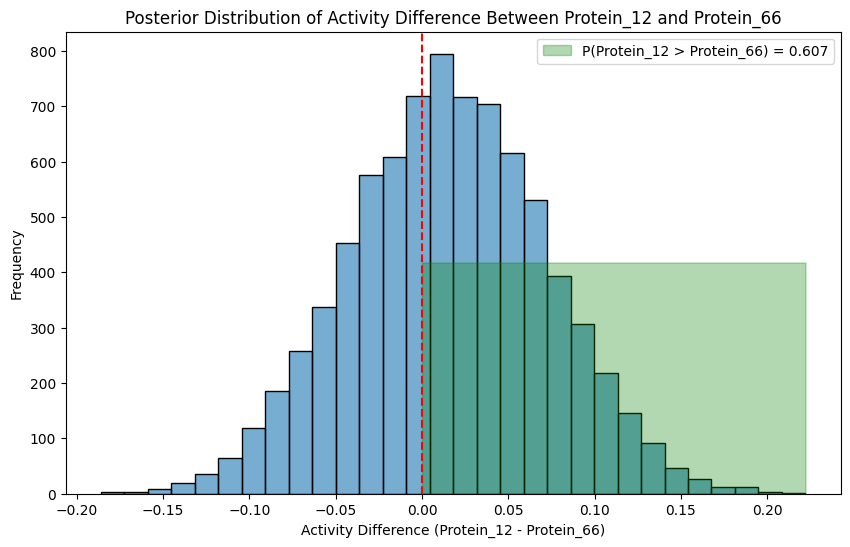

In [ ]:
def _():
    # Get posterior samples
    prot_activity = trace.posterior["prot_activity"].values
    prot_activity_flat = prot_activity.reshape(-1, prot_activity.shape[2])

    # Get protein names
    protein_names = trace.posterior["protein"].values

    # Choose two proteins to compare
    protein1 = "Protein_12"  # A high performer
    protein2 = "Protein_66"  # Another high performer

    idx1 = np.where(protein_names == protein1)[0][0]
    idx2 = np.where(protein_names == protein2)[0][0]

    # Extract their posterior samples
    samples1 = prot_activity_flat[:, idx1]
    samples2 = prot_activity_flat[:, idx2]

    # Calculate differences for each posterior sample
    differences = samples1 - samples2

    # Calculate superiority probability
    prob_superiority = np.mean(differences > 0)

    # Plot the posterior of differences
    plt.figure(figsize=(10, 6))

    # Histogram of differences
    sns.histplot(differences, bins=30, alpha=0.6)

    # Add vertical line at zero
    plt.axvline(x=0, color="r", linestyle="--")

    # Shade the area where protein1 > protein2
    positive_mask = differences > 0
    plt.fill_between(
        np.sort(differences[positive_mask]),
        0,
        plt.gca().get_ylim()[1] / 2,  # Half height for visibility
        alpha=0.3,
        color="green",
        label=f"P({protein1} > {protein2}) = {prob_superiority:.3f}",
    )

    plt.xlabel(f"Activity Difference ({protein1} - {protein2})")
    plt.ylabel("Frequency")
    plt.title(
        "Posterior Distribution of Activity Difference "
        f"Between {protein1} and {protein2}"
    )
    return plt.legend()

_()

This visualization demonstrates the core concept. The green shaded area represents
the proportion of posterior samples where the first protein outperforms the second.
This proportion is the probability of superiority.

Rather than reducing our rich posterior distributions to point estimates or effect sizes
that still require interpretation, the superiority probability directly integrates over
all uncertainty to answer our precise question: "How likely is it that this protein is
better than that one?"

Now let's calculate this for all pairs of proteins to create a comprehensive superiority matrix:

In [ ]:
from tqdm.auto import tqdm

def _():
    n_proteins = trace.posterior["prot_activity"].shape[-1]
    prot_activity = trace.posterior["prot_activity"].values.reshape(-1, n_proteins)

    superiority_matrix = np.zeros((n_proteins, n_proteins))

    for i in tqdm(range(n_proteins)):
        for j in range(n_proteins):
            if i != j:
                superiority_matrix[i, j] = np.mean(
                    prot_activity[:, i] > prot_activity[:, j]
                )
    return superiority_matrix

superiority_matrix = _()

  0%|                                                                                       | 0/95 [00:00<?, ?it/s]

 62%|███████████████████████████████████████████████▊                             | 59/95 [00:00<00:00, 585.08it/s]

100%|█████████████████████████████████████████████████████████████████████████████| 95/95 [00:00<00:00, 587.17it/s]


This superiority matrix gives us, for each pair of proteins (i, j), the probability
that protein i has higher activity than protein j, incorporating all model uncertainty.

The calculation yields a probability interpretation: "There's an 85% chance that
protein A is superior to protein B" rather than the frequentist "protein A is
significantly better than protein B with p<0.05."

Let's visualize this matrix:

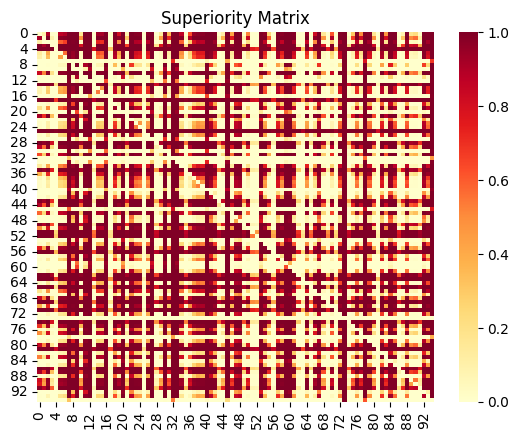

In [ ]:
# Create heatmap
sns.heatmap(superiority_matrix, annot=False, cmap="YlOrRd", fmt=".2f")
plt.title("Superiority Matrix")
plt.gca()

We can rank proteins by their average probability of superiority across all comparisons:

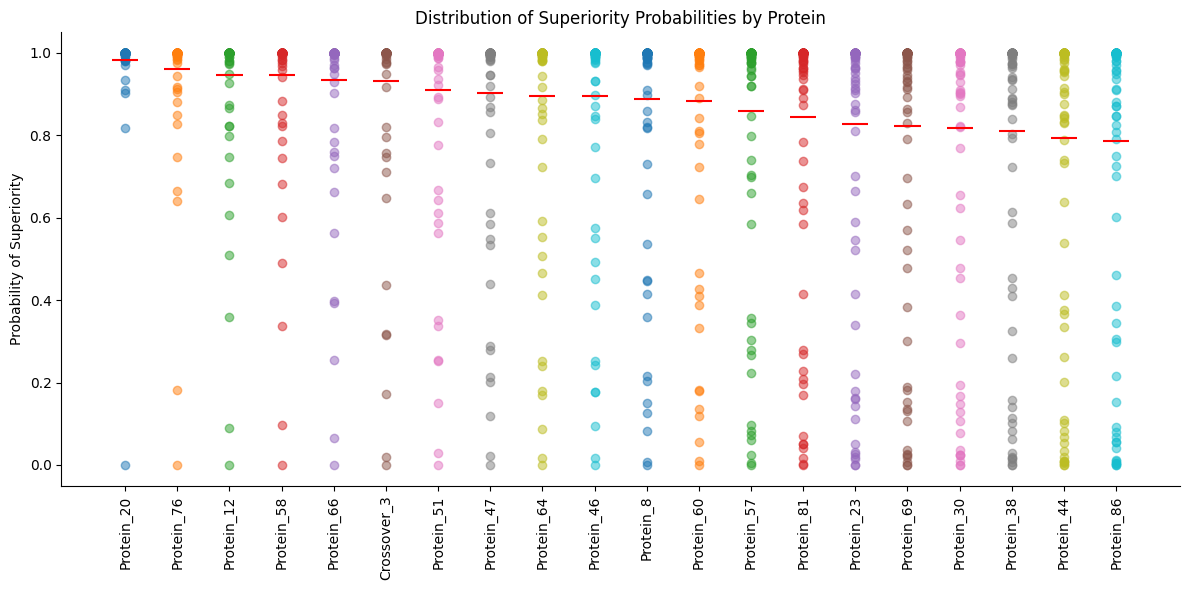

In [ ]:
def _():
    # Calculate average probability of superiority and sort proteins
    avg_superiority = superiority_matrix.mean(axis=1)
    protein_names = df["Protein"].unique()
    superiority_df = pd.DataFrame(
        {"Protein": protein_names, "Avg_Superiority": avg_superiority}
    )
    sorted_superiority = superiority_df.sort_values(
        "Avg_Superiority", ascending=False
    ).head(20)

    # Create plot
    plt.figure(figsize=(12, 6))

    # For each protein, plot individual points and mean line
    for i, protein in enumerate(sorted_superiority["Protein"]):
        protein_idx = np.where(protein_names == protein)[0][0]
        protein_probs = superiority_matrix[protein_idx]
        plt.scatter([i] * len(protein_probs), protein_probs, alpha=0.5)
        plt.hlines(avg_superiority[protein_idx], i - 0.25, i + 0.25, color="red")

    plt.xticks(
        range(len(sorted_superiority)), sorted_superiority["Protein"], rotation=90
    )
    plt.ylabel("Probability of Superiority")
    plt.title("Distribution of Superiority Probabilities by Protein")
    plt.tight_layout()
    sns.despine()
    return plt.gca()

_()

This ranking differs from what we might conclude by examining forest plots alone.
The superiority metric directly quantifies the probability that one protein
outperforms others, properly accounting for the full posterior distribution
and uncertainty in each comparison.

To better understand how protein activity relates to superiority probability,
let's compare their posterior mean activity with two superiority measures:

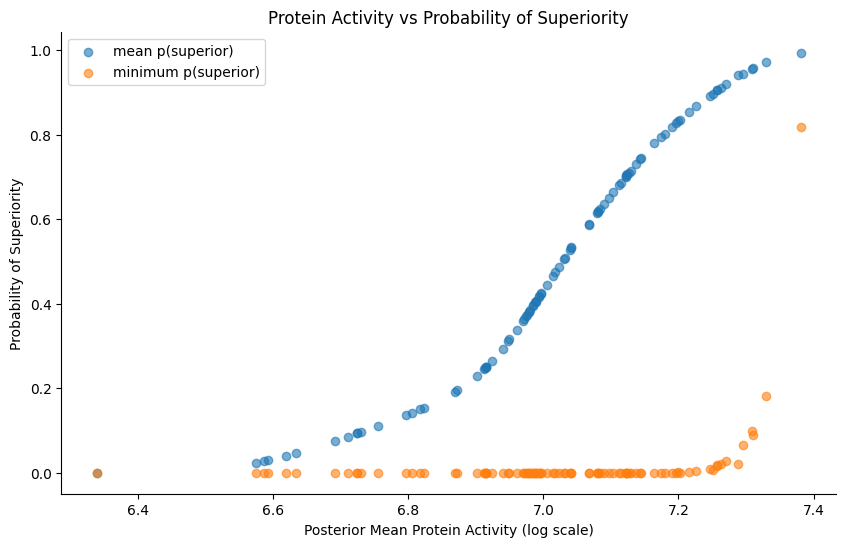

In [ ]:
def _():
    # Calculate probability of superiority distribution for each protein
    superiority_dist = [
        np.concatenate([superiority_matrix[i, :j], superiority_matrix[i, j + 1 :]])
        for i, j in enumerate(range(len(superiority_matrix)))
    ]

    # Get protein activity statistics from trace
    protein_activity_mean = (
        trace.posterior["prot_activity"].mean(dim=["chain", "draw"]).values
    )

    # Create scatter plot
    plt.figure(figsize=(10, 6))

    # Plot points
    plt.scatter(
        protein_activity_mean,
        [np.mean(dist) for dist in superiority_dist],
        alpha=0.6,
        label="mean p(superior)",
    )
    plt.scatter(
        protein_activity_mean,
        [np.percentile(dist, q=0) for dist in superiority_dist],
        alpha=0.6,
        label="minimum p(superior)",
    )

    plt.xlabel("Posterior Mean Protein Activity (log scale)")
    plt.ylabel("Probability of Superiority")

    plt.legend()
    plt.title("Protein Activity vs Probability of Superiority")
    sns.despine()
    return plt.gca()

_()

This plot reveals that:

1. The relationship between activity and superiority is non-linear
2. Proteins with similar activities can have different superiority probabilities
   depending on the certainty of their estimates
3. The minimum probability of superiority provides a conservative decision-making
   measure—a protein with high minimum superiority is more likely to be the superior
   candidate

## Conclusion

When screening candidates, two questions are critical: "Are we measuring what matters?"
and "Which candidates are truly superior?" Traditional approaches using point estimates
and p-values inadequately address these questions when dealing with experimental noise
and multiple comparisons.

A Bayesian model with explicitly modeled terms offers a powerful alternative:

1. **R2D2 priors** decompose variance into interpretable components, revealing how
   much signal comes from the biological effect versus experimental artifacts.
   This guides concrete improvements to experimental protocols.

2. **Bayesian superiority calculation** directly quantifies the probability that
   one candidate outperforms others, properly accounting for uncertainty and
   avoiding the pitfalls of simple rank ordering.

These techniques transform screening data into actionable insights and apply to
any domain requiring robust comparison of multiple candidates under noisy conditions:
drug discovery, materials science, A/B testing, clinical trials, and more.

Bayesian methods move us beyond simplistic "winners and losers" to a nuanced
understanding of which candidates are most likely to succeed, with what degree
of certainty, and how we can improve our measurement process itself.